<a href="https://colab.research.google.com/github/TonyReyesM/Fisica-Computacional/blob/master/Evaluaci%C3%B3n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación 1
Antonio Reyes Montaño

In [ ]:
#Importamos bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

***Parte 1:*** Construcción de serie de tiempo

In [ ]:
#Se utilizará el archivo de datos de Alaska
#El archivo indica que los datos inician después del renglón 151
#Creamos una lista de nombres para las columnas
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_brw_DailyData.txt'
df_cols=['Site code', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Time decimal', 'Value', 'Value std dev', 'nValue', 'Latitude', 'Longitude', 'Altitude', 'Elevation', 
         'Intake Flight', 'QCFlag' ]
#Creamos el dataframe sin los primeras 151 renglones, y asignamos los nombres de las columnas y combinamos en una sola las colimnas de año mes y día
data = pd.read_csv(url, names=df_cols, encoding='cp1251', sep='\s+', header=None, skiprows=151, skipfooter=1, engine='python', parse_dates = [['Year', 'Month', 'Day']])
#Revisamos los primeros y últimos renglones
#print(data.head())
#print(data.tail())

#Necesitamos las columnas de las fechas y la columna value
#Creamos una copia para un nuevo dataframe para trabajar con él
data_0 = data.copy()
#Nos quedamos con las 4 columnas que necesitamos
data_0 = data_0[['Year_Month_Day','Value']]
#Visualizamos el nuevo dataframe
#data_0.head()

#Ahora sustituimos los valores de -999.99 ya que son datos nulos.
data_1 = data_0.replace(to_replace = -999.99, value = '', regex = True)
data_1['Value'] = pd.to_numeric(data_1['Value'], errors = 'coerce')
#Revisamos los primeros y últimos datos, la información del dataframe, y un pequeño análisis estadístico
#print(data_1.head())
#print(data_1.tail())
#data_1.info()
#data_1.describe().round(3)

#Creamos una copia del dataframe para seguir trabajando
data_2 = data_1.copy()
#Renombramos las columnas
data_2.rename(columns={'Year_Month_Day': 'Fecha', 'Value': 'CO2'}, inplace = True)
data_2['Fecha'] = pd.to_datetime(data_2['Fecha'], dayfirst = True)
#Creamos columnas de año y mes por separado
data_2['Año'] = data_2['Fecha'].dt.year
#data_2['Mes'] = data_2['Fecha'].dt.strftime('%b')
#Revisamos la información del nuevo dataframe
#data_2.info()
#print(data_2.head())
#print(data_2.tail())

#Creamos otra copia de trabajo que será nuestra serie de tiempo
data_3 = data_2.copy()
#Convertimos el dataframe en una serie de tiempo con la fecha como índice
data_3 = data_3.set_index('Fecha')
#Nos quedamos con los datos de 1980 al 2019
ts_test = data_3[(data_3['Año'] >= 1980) & (data_3['Año'] <= 2019)]
#Eliminamos la columna de año
ts_test.drop('Año', axis = 1, inplace = True)
#Rellenamos los valores vacíos
ts_test.ffill(axis = 0, inplace=True)
#Revisamos el dataframe
ts_test.info()
print(ts_test.head())
print(ts_test.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14609 entries, 1980-01-01 to 2019-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     14609 non-null  float64
dtypes: float64(1)
memory usage: 228.3 KB
               CO2
Fecha             
1980-01-01  341.38
1980-01-02  341.65
1980-01-03  341.65
1980-01-04  341.65
1980-01-05  341.65
               CO2
Fecha             
2019-12-26  416.98
2019-12-27  416.86
2019-12-28  416.83
2019-12-29  417.01
2019-12-30  417.65


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


***Parte 2:*** Análisis de la serie de tiempo

* Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)

In [ ]:
#Definimos la función de prueba de estacionaridad utilizando la prueba avanzada de Dickey-Fuller 
def test_stationarity(sTiempo):
    
    #Determinar la Estadística de promedios y desviación estándar móviles
    rolProm = sTiempo.rolling(window=365, center=True).mean()
    rolStd = sTiempo.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(sTiempo, color='green',label='Original')
    plt.plot(rolProm, color='red', label='Promedio móvil')
    plt.plot(rolStd, color='black', label = 'Desviación estándar móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(sTiempo, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

* Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.

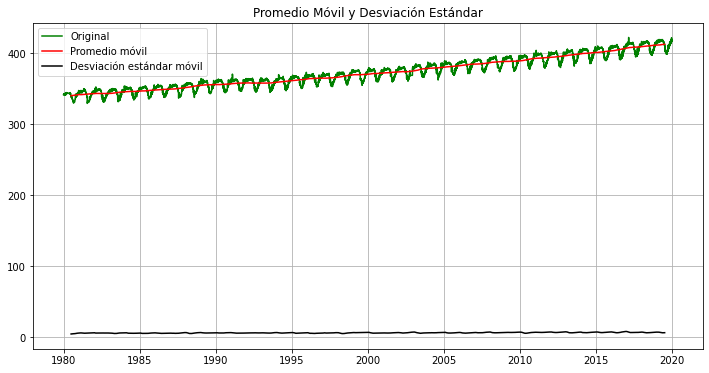

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -3.236940
p-value                            0.017944
#Lags Used                        37.000000
Number of Observations Used    14571.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
#Revisamos la estacionaridad de nuestra serie de tiempo con la función creada
test_stationarity(ts_test['CO2'])

Vemos que tenemos un valor pequeño para el **valor p (0.017944)**, por lo que la serie es **estacionaria**

* Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto).

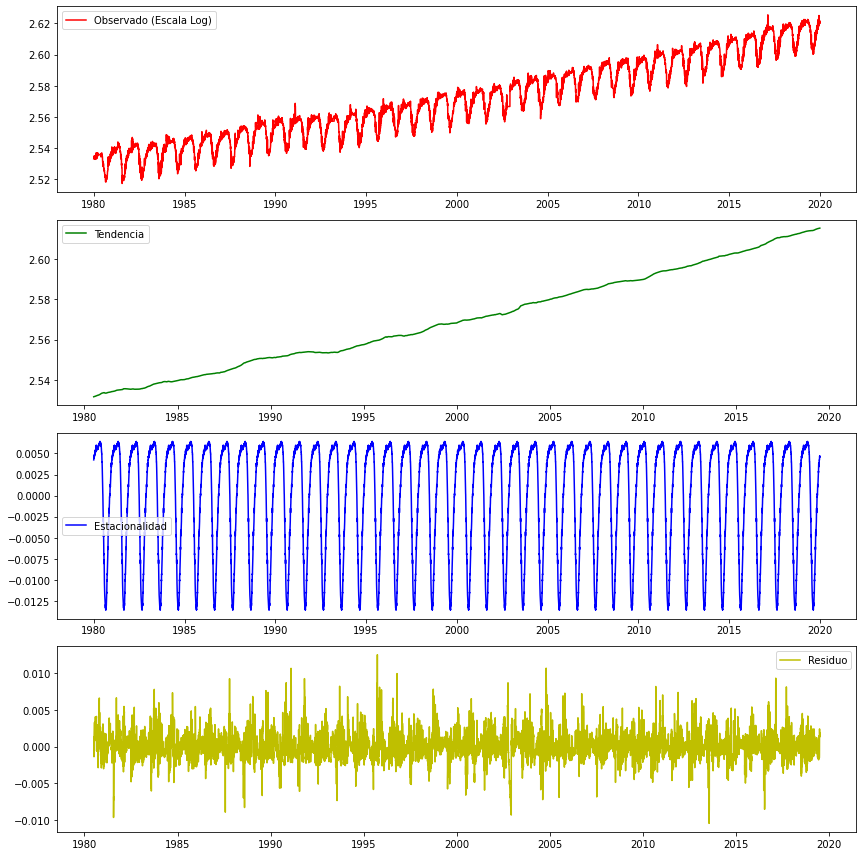

In [ ]:
#Creamos la función logarítmica
ts_test_log = np.log10(ts_test)
#Calculamos su promedio móvil
promMov = ts_test_log.rolling(365, center=True).mean()

#Descomponemos la serie de tiempo logarítmica y obtenemos las componentes de tendencia, estacionalidad y residuo
ts_decomp = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)
ts_trend = ts_decomp.trend
ts_season = ts_decomp.seasonal
ts_res = ts_decomp.resid

# Graficamos las componentes obtenidas
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)', color = 'r')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(ts_trend, label='Tendencia', color = 'g')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(ts_season, label='Estacionalidad', color = 'b')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(ts_res, label='Residuo', color = 'y')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();



1.   Observamos que la **tendencia** indica un aumento de los niveles de CO2 a través de los años.
2.   Observamos como la **estacionalidad** crea aumentos y descensos periódicos en los niveles de CO2, pero la tendencia provoca que los valores alrededor de los que oscilan los aumentos y descensos vayan creciendo.
3.   El **residuo** parece ser algo así como ruido en las mediciones de CO2.



* Prueba la estacionaridad de la serie residuo.  

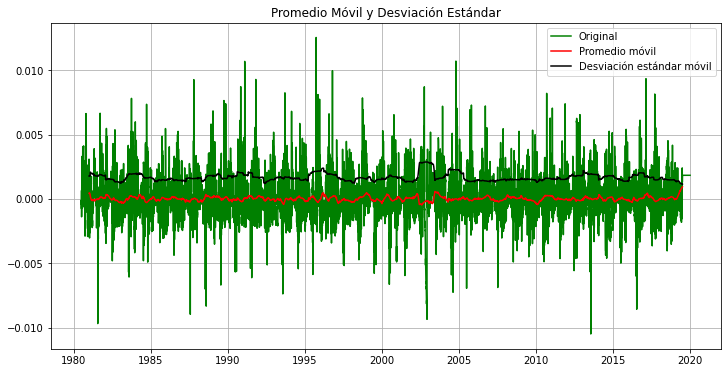

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -22.490876
p-value                            0.000000
#Lags Used                        12.000000
Number of Observations Used    14414.000000
Critical Value (1%)               -3.430804
Critical Value (5%)               -2.861741
Critical Value (10%)              -2.566877
dtype: float64


In [ ]:
#Quitamos los valores vacíos en la componente de residuo y probamos la estacionaridad de la componente de residuo
ts_res.dropna(inplace=True)
test_stationarity(ts_res['CO2'])

Observamos que el valor p es 0 por lo que la serie es estacionaria

* Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.

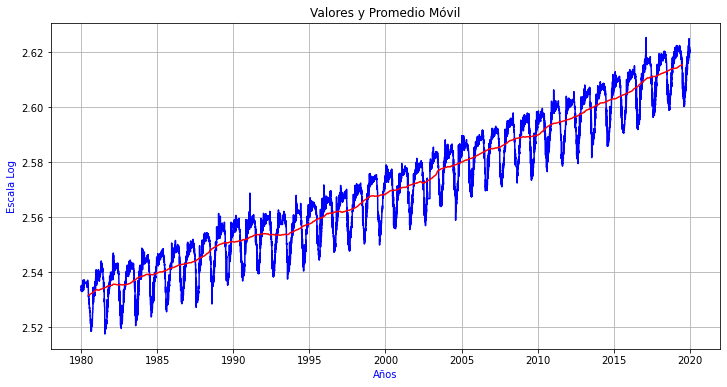

In [ ]:
#Graficamos la serie logarítmica junto con el promedio móvil para visualizar
plt.plot(ts_test_log, color = 'b', label = 'ts_test_log')
plt.plot(promMov, color = 'r', label = 'Promedio móvil')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

* Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.

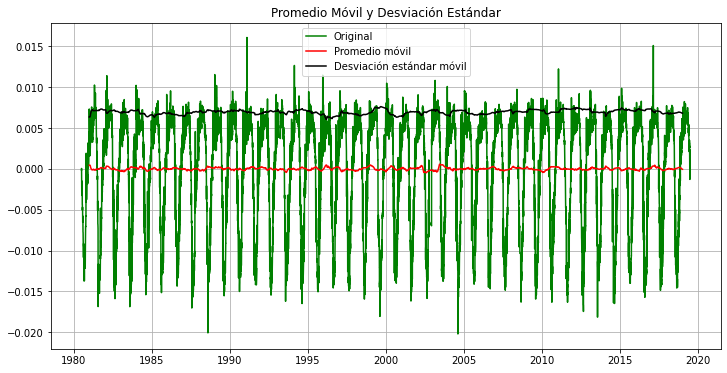

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.483177e+01
p-value                        1.894479e-27
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
#Creamos el dataframe de la diferencia entre la serie logarítmica y el promedio móvil
ts_test_log_diff = ts_test_log - promMov
#Quitamos valores nulos
ts_test_log_diff.dropna(inplace=True)
#Revisamos la estacionaridad de este nuevo dataframe
test_stationarity(ts_test_log_diff['CO2'])

Vemos que el valor p es de 1.89x10^-27 (prácticamente 0), lo cual es un valor muy pequeño e indica **estacionaridad** en la serie.

* Adicionalmente, prueba construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil.   

* Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.

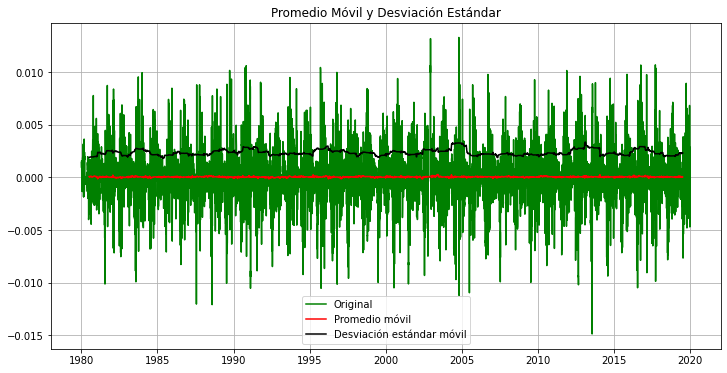

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.141389e+01
p-value                        7.139830e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [ ]:
#Creamos otro dataframe similar pero con la función .shift con prediodo de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
#Quitamos valores nulos
ts_test_log_diff.dropna(inplace=True)
#Revisamos la estacionaridad de este nuevo dataframe
test_stationarity(ts_test_log_diff['CO2'])

El valor p es de 7.14x10^-21, muy cercano a 0, por lo que tenemos una serie **estacionaria**

* Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez)  

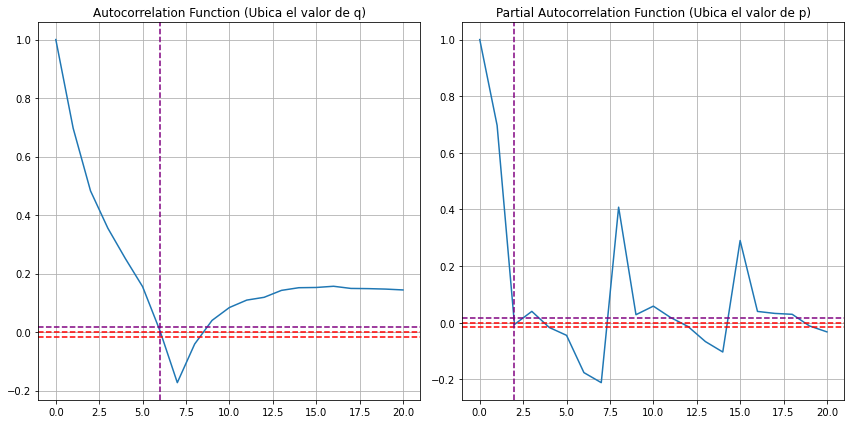

In [ ]:
#Creamos un modelo ARIMA
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (12,6)

#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
#Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=6, linestyle='--', color='purple')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

#Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
#Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='purple')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

 

1. Observamos que la ACF cruza el primer nivel de confianza cerca del 6 entonces: **q=6**
2. Observamos que la PACF cruza el primer nivel de confianza cerca del 2, entonces: **p=2**



* Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q).

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14608
Model:                 ARIMA(2, 1, 0)   Log Likelihood               76726.319
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -153444.637
Time:                        02:04:30   BIC                        -153414.280
Sample:                    01-02-1980   HQIC                       -153434.552
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.975e-06    7.8e-06      0.766      0.444   -9.32e-06    2.13e-05
ar.L1.D.CO2    -0.1744      0.008    -21.386      0.000      -0.190      -0.158
ar.L2.D.CO2    -0.1687      0.008    -20.688    

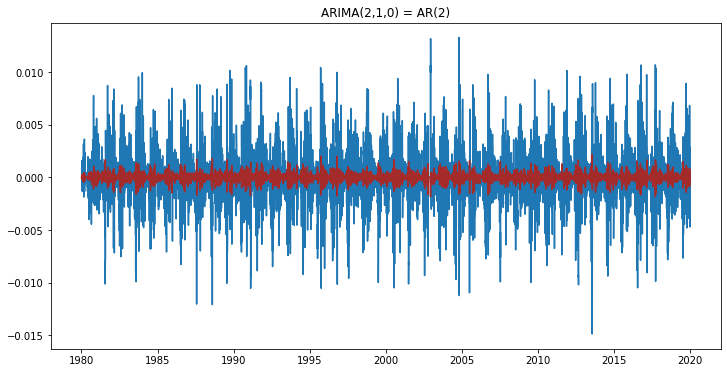

In [ ]:
#Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14608
Model:                 ARIMA(0, 1, 6)   Log Likelihood               76857.826
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -153699.652
Time:                        02:04:40   BIC                        -153638.937
Sample:                    01-02-1980   HQIC                       -153679.481
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         5.96e-06   5.87e-06      1.015      0.310   -5.54e-06    1.75e-05
ma.L1.D.CO2    -0.2029      0.008    -24.520      0.000      -0.219      -0.187
ma.L2.D.CO2    -0.1659      0.008    -19.581    

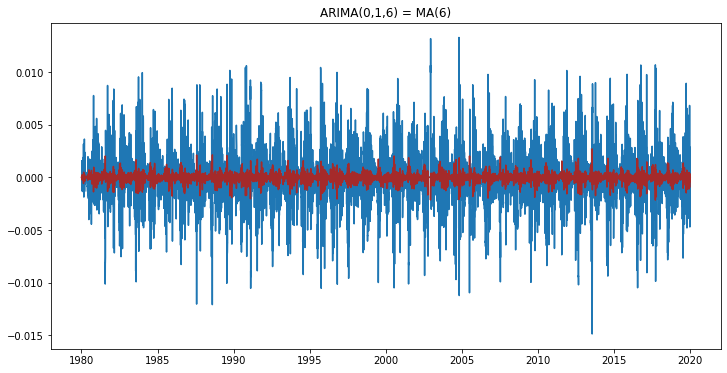

In [ ]:
#Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14608
Model:                 ARIMA(2, 1, 6)   Log Likelihood               76967.506
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -153915.011
Time:                        02:08:00   BIC                        -153839.118
Sample:                    01-02-1980   HQIC                       -153889.798
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.069e-06   1.17e-05      0.518      0.604   -1.69e-05     2.9e-05
ar.L1.D.CO2     0.1182        nan        nan        nan         nan         nan
ar.L2.D.CO2     0.8383        nan        nan    

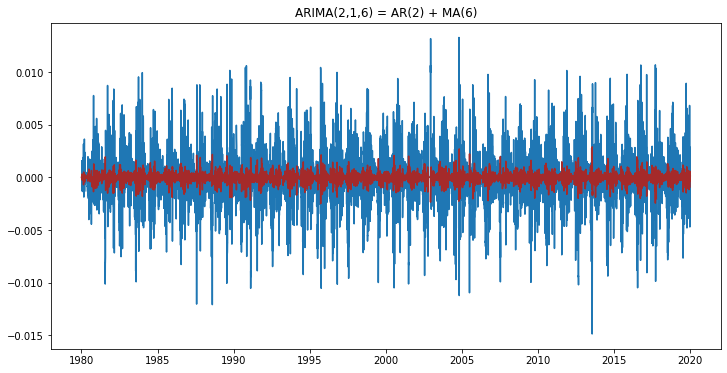

In [ ]:
#Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

1. *Modelo AR:* **AIC = -153444.637**
2. *Modelo MA:* **AIC = -153699.652**
3. *Modelo ARIMA:* **AIC = -153915.011**

El modelo con el AIC más adecuado es entonces el ARIMA

* Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.

In [ ]:
#Creamos la serie de tiempo con los datos de las prediccións de ARIMA
ARIMA_ts = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_ts)

Fecha
1980-01-02    0.000006
1980-01-03   -0.000042
1980-01-04   -0.000050
1980-01-05   -0.000030
1980-01-06   -0.000027
                ...   
2019-12-26   -0.000278
2019-12-27    0.000035
2019-12-28    0.000208
2019-12-29    0.000121
2019-12-30    0.000170
Length: 14608, dtype: float64


In [ ]:
#Sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
ARIMA_log = pd.Series(ts_test_log['CO2'], index = ts_test_log['CO2'].index)
ARIMA_log = ARIMA_log.add(ARIMA_ts)
print(ARIMA_log.head())
print(ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.533587
1980-01-03    2.533539
1980-01-04    2.533532
1980-01-05    2.533552
dtype: float64
Fecha
2019-12-26    2.619837
2019-12-27    2.620025
2019-12-28    2.620167
2019-12-29    2.620268
2019-12-30    2.620983
dtype: float64


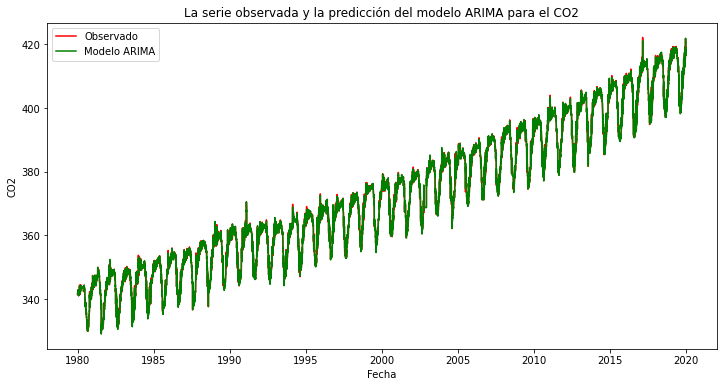

In [ ]:
# Regresamos a la escala original
ARIMA_ts = 10**(ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test, label='Observado', color = 'r');
plt.plot(ARIMA_ts, label='Modelo ARIMA', color = 'g');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

* Calcula el error RMSE

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((ARIMA_ts - ts_test['CO2'])**2))
print('RMSE:', RMSE)

RMSE: 0.3364160535634778


* Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

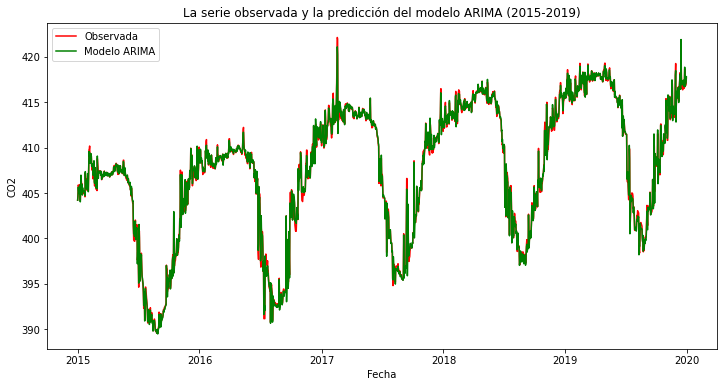

In [ ]:
#Graficando los últimos 5 años de las series 
ts_test_last = ts_test.tail(1825)
ARIMA_ts_last = ARIMA_ts.tail(1825)
plt.plot(ts_test_last, label='Observada', color = 'r');
plt.plot(ARIMA_ts_last, label='Modelo ARIMA', color = 'g');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA (2015-2019)')
plt.legend(loc='best');